##### Calculate Physician Q values ( MDP)

In [1]:
# import required libraries 
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import os
import joblib
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import cpu_count
import tqdm
import statistics
from tqdm import tqdm
from luca_utils import *
import warnings
warnings.filterwarnings('ignore')

#### Setting directory and load the data 

In [2]:
# import your RL data dict from this directory 
data_dir = 'C:/Users/gmpxe/Downloads/MIMIC_data_allbins.csv/Luca_experiment/data/'
data_file = 'Luca_data_dict.pkl'
# write your physician Q- iterated values here 
out_dir = 'C:/Users/gmpxe/Downloads/MIMIC_data_allbins.csv/Luca_experiment/data/'

#figures 
fig_dir = 'C:/Users/gmpxe/Downloads/MIMIC_data_allbins.csv/Luca_experiment/figures/'

# load data 
data_dict = joblib.load(os.path.join(data_dir, data_file))
print(data_dict.keys())

dict_keys(['train', 'val', 'test', 'v', 'featurenames'])


##### Set Configuration for running the model

In [3]:
config = {'FQI_SEED': 42,                               
          'gamma': 0.9,
          'FQI_iterations': 100,                       
          'max_depth': 5, 
          'n_estimators': 80,
         }
config_df = pd.DataFrame(config, index=[0])
config_df.to_csv(os.path.join(out_dir, 'FQIconfig.csv'), index=False)

#set evaluation type 
eval_set= ['train', 'val', 'test']
gamma = 0.9

##### write function to get sarsa dict  

In [4]:
### prepare data for runing FQI-SARSA model 
def get_SARSA_data(data_dict, eval_type='val'):
    #get transition dict 
    transition_dict = dict(zip(data_dict[eval_type]['state_id'], 
                                data_dict[eval_type]['next_state_id']))
    
    # get state_ID's and next_state_ID's
    batch_ids = data_dict[eval_type]['state_id']
    next_state_batch_ids = [transition_dict[x] for x in batch_ids]
    #get states
    state_features = data_dict[eval_type]['X'][(batch_ids)]
    state_features[np.where(np.isinf(state_features))] = 0 # impute inf by mean
    #get action 
    actions = data_dict[eval_type]['action'][(batch_ids)]
    #get reward 
    reward = data_dict[eval_type]['reward'][(batch_ids)]
    #get next state
    next_state_features = data_dict[eval_type]['X'][(next_state_batch_ids)]
    next_state_features[np.where(np.isinf(next_state_features))] = 0
# define the reward mask. In case of the end of a trajectory, the MaxQN(state,action) function should be zero... (no more future discounted reward after final state)
    reward_mask = []
    for i in range(state_features.shape[0]):
        if (batch_ids[i] == next_state_batch_ids[i]):
            reward_mask += [False] 
        else:
            reward_mask += [True]
    sarsa_dict = {'batch_ids' : batch_ids,
                'next_state_batch_ids' :  next_state_batch_ids,
                'state' :  state_features, 
                'actions' : actions,  
                 'next_state' : next_state_features,
                'rewards' : reward,
                'reward_mask' : reward_mask}
    return sarsa_dict


### Function to get FQI modeling data 

In [5]:
def get_state_action_modelingdata(data_dict, sarsa_dict):
    for i in tqdm(np.unique(data_dict[eval_type]['action'])):
        next_state_action= np.concatenate((sarsa_dict['next_state'], 
                           np.transpose([np.repeat(i,sarsa_dict['next_state'].shape[0])])), axis=1)
        next_state_action_unique_state_id = np.concatenate((next_state_action,
                                            np.transpose(np.array([sarsa_dict['batch_ids']]))), axis=1)
        if(i==0): 
            all_next_states_all_possible_actions = pd.DataFrame.from_records(next_state_action_unique_state_id)
        
        else: 
            all_next_states_all_possible_actions = all_next_states_all_possible_actions.append(pd.DataFrame.from_records(next_state_action_unique_state_id))
    
    # Add column names for continuous model features
    feature_names = data_dict['featurenames'].tolist()
    # Add action to feature space
    feature_and_action_names = feature_names + ['action']
    # Add state ID to dataframe 
    column_names = feature_and_action_names + ['state_id']
    # add the column names to the dataframe
    all_next_states_all_possible_actions.columns = column_names
    print('shape of action state  combination: ', all_next_states_all_possible_actions.shape)
    expected_row = sarsa_dict['state'].shape[0] * np.unique(data_dict[eval_type]['action']).shape[0]
    expected_col = len(data_dict['featurenames']) + 3
    print('expected dim is : ', expected_row, ' ', expected_col)
    
    ### Create features for random forest
    # Create dummy variables for actions
    action_dummies = np.array(pd.get_dummies(sarsa_dict['actions']))
    # initial X (set of states and taken actions at time t from 0 to T)
    X = np.concatenate([sarsa_dict['state'], action_dummies], axis=1) # original state and not next state here

    # initialize the Q_minus_1 function, set at 0 for N==0.
    all_next_states_all_possible_actions["Qvalue"] = 0
    cont_Q_minus_1 = all_next_states_all_possible_actions.groupby(['state_id'], sort=False)['Qvalue'].max()
    # construct the output for the regressor function ~ reward mask is False if state is terminal in which case there is no "future discounted reward, only current state reward"\
    gamma = config['gamma']
    #R+y(Q(s,a))
    output = sarsa_dict['rewards'] + gamma * (cont_Q_minus_1 * sarsa_dict['reward_mask'])

    #features for rest of the iterative models (big matrix)
    feat = np.concatenate([all_next_states_all_possible_actions[feature_names], 
           pd.get_dummies(all_next_states_all_possible_actions['action'])], axis=1)
    print('dim of X is ', X.shape)
    print('dim of features big matrix is ', feat.shape)
    print('shape of y or output is ', output.shape)

    return X, output, feat, all_next_states_all_possible_actions

    

##### Function to predict and save Physiscian MDP current state 

In [6]:
def save_physician_mdp(data_dict, sarsa_dict):
    for i in np.unique(data_dict[eval_type]['action']):
        current_state_action = np.concatenate((sarsa_dict['state'], 
                           np.transpose([np.repeat(i,sarsa_dict['state'].shape[0])])), axis=1)
        current_state_action_unique_state_id = np.concatenate((current_state_action,
                                               np.transpose(np.array([sarsa_dict['batch_ids']]))), axis=1)
        if(i==0): 
            all_current_states_all_possible_actions = pd.DataFrame.from_records(current_state_action_unique_state_id)
            print("\nDimensions of the dataset that is being appended with it's base length for each action:")
            print(all_current_states_all_possible_actions.shape)
        else: 
            all_current_states_all_possible_actions = all_current_states_all_possible_actions.append(pd.DataFrame.from_records(current_state_action_unique_state_id))
    # Add column names for continuous model features
    feature_names = data_dict['featurenames'].tolist()

    # Add action to feature space
    feature_and_action_names = feature_names + ['action']

    # Add state ID to dataframe 
    column_names = feature_and_action_names + ['state_id']
    # add the column names to the dataframe
    all_current_states_all_possible_actions.columns = column_names
    # add empty Qvalue column
    all_current_states_all_possible_actions['Qvalue'] = 0
    ## add dummies back to all_current_states_all_possible_actions
    current_state_all_possible_actions_dummies = np.concatenate([all_current_states_all_possible_actions[feature_names], 
                                                 pd.get_dummies(all_current_states_all_possible_actions['action'])], axis=1)
    # assign new Q values to dataframe
    all_current_states_all_possible_actions['Qvalue'] = cont_regr.predict(current_state_all_possible_actions_dummies)

    # create an output dataframe with the Q values (25 collumns) for each state (rows) for the 'eval_type' dataset
    cont_results_df = all_current_states_all_possible_actions.pivot_table(values='Qvalue', index='state_id', columns='action')

    # add Q values for each unique action
    cont_results_df.columns = ['Q' + str(i) for i in np.unique(data_dict[eval_type]['action'])]

    # save to pickle
    cont_results_df = np.around(cont_results_df,decimals=3)
    return cont_results_df

##### Dictionary to store FQI performances 

In [7]:
# Before FQI loop:
cont_performance_dict = {'train': {
                             'iteration':[],
                             'loss':[],
                             'meanQ': [],
                             'Qvar': []
                             },
                    'val': {
                             'iteration':[],
                             'loss':[],
                             'meanQ': [],
                             'Qvar': []
                             },
                    'test': {
                             'iteration':[],                             
                             'loss':[],
                             'meanQ': [],
                             'Qvar': []
                             }
                   }

#### Running and visualizing the model 

running fqi for eval_type  val


100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


shape of action state  combination:  (605178, 49)
expected dim is :  605178   50
dim of X is  (28818, 68)
dim of features big matrix is  (605178, 68)
shape of y or output is  (28818,)


  1%|          | 1/100 [00:03<05:52,  3.56s/it]

Iteration: 0, val Loss: 0.365543, meanQ: 0.996439, Qvar: 1.981032


  2%|▏         | 2/100 [00:06<05:14,  3.21s/it]

Iteration: 1, val Loss: 0.223384, meanQ: 1.693801, Qvar: 4.187491


  3%|▎         | 3/100 [00:09<04:54,  3.03s/it]

Iteration: 2, val Loss: 0.106972, meanQ: 2.313360, Qvar: 6.190597


  4%|▍         | 4/100 [00:12<04:48,  3.00s/it]

Iteration: 3, val Loss: 0.005548, meanQ: 2.918855, Qvar: 7.515344


  5%|▌         | 5/100 [00:15<04:39,  2.94s/it]

Iteration: 4, val Loss: -0.062770, meanQ: 3.339315, Qvar: 8.468507


  6%|▌         | 6/100 [00:18<04:41,  3.00s/it]

Iteration: 5, val Loss: -0.114115, meanQ: 3.680704, Qvar: 9.070250


  7%|▋         | 7/100 [00:21<04:50,  3.12s/it]

Iteration: 6, val Loss: -0.153417, meanQ: 3.960977, Qvar: 9.421972


  8%|▊         | 8/100 [00:24<04:48,  3.14s/it]

Iteration: 7, val Loss: -0.184987, meanQ: 4.192536, Qvar: 9.570292


  9%|▉         | 9/100 [00:28<04:51,  3.20s/it]

Iteration: 8, val Loss: -0.212701, meanQ: 4.402612, Qvar: 9.493547


 10%|█         | 10/100 [00:31<04:51,  3.24s/it]

Iteration: 9, val Loss: -0.231395, meanQ: 4.541687, Qvar: 9.503420


 11%|█         | 11/100 [00:35<04:56,  3.33s/it]

Iteration: 10, val Loss: -0.245672, meanQ: 4.650238, Qvar: 9.443989


 12%|█▏        | 12/100 [00:38<04:50,  3.30s/it]

Iteration: 11, val Loss: -0.259766, meanQ: 4.763801, Qvar: 9.222121


 13%|█▎        | 13/100 [00:41<04:59,  3.44s/it]

Iteration: 12, val Loss: -0.271452, meanQ: 4.861899, Qvar: 8.990463


 14%|█▍        | 14/100 [00:45<04:57,  3.46s/it]

Iteration: 13, val Loss: -0.285513, meanQ: 4.980782, Qvar: 8.650587


 15%|█▌        | 15/100 [00:48<04:54,  3.46s/it]

Iteration: 14, val Loss: -0.293364, meanQ: 5.042405, Qvar: 8.536989


 16%|█▌        | 16/100 [00:52<04:50,  3.46s/it]

Iteration: 15, val Loss: -0.297012, meanQ: 5.066203, Qvar: 8.606000


 17%|█▋        | 17/100 [00:55<04:42,  3.40s/it]

Iteration: 16, val Loss: -0.299041, meanQ: 5.074593, Qvar: 8.749496


 18%|█▊        | 18/100 [00:59<04:41,  3.44s/it]

Iteration: 17, val Loss: -0.300333, meanQ: 5.081354, Qvar: 8.827505


 19%|█▉        | 19/100 [01:02<04:44,  3.51s/it]

Iteration: 18, val Loss: -0.300700, meanQ: 5.085751, Qvar: 8.819374


 20%|██        | 20/100 [01:06<04:36,  3.45s/it]

Iteration: 19, val Loss: -0.301193, meanQ: 5.093515, Qvar: 8.737691


 21%|██        | 21/100 [01:09<04:29,  3.41s/it]

Iteration: 20, val Loss: -0.302201, meanQ: 5.104804, Qvar: 8.662420


 22%|██▏       | 22/100 [01:12<04:26,  3.42s/it]

Iteration: 21, val Loss: -0.304812, meanQ: 5.123915, Qvar: 8.614887


 23%|██▎       | 23/100 [01:16<04:17,  3.35s/it]

Iteration: 22, val Loss: -0.312618, meanQ: 5.193709, Qvar: 8.513163


 24%|██▍       | 24/100 [01:19<04:13,  3.34s/it]

Iteration: 23, val Loss: -0.318388, meanQ: 5.248991, Qvar: 8.433893


 25%|██▌       | 25/100 [01:22<04:06,  3.29s/it]

Iteration: 24, val Loss: -0.322763, meanQ: 5.290962, Qvar: 8.363460


 41%|████      | 41/100 [02:11<02:56,  3.00s/it]

Iteration: 40, val Loss: -0.333739, meanQ: 5.417762, Qvar: 7.924397


 61%|██████    | 61/100 [03:13<01:58,  3.04s/it]

Iteration: 60, val Loss: -0.328443, meanQ: 5.364824, Qvar: 8.030225


 81%|████████  | 81/100 [04:15<01:00,  3.21s/it]

Iteration: 80, val Loss: -0.327322, meanQ: 5.356732, Qvar: 8.096674


100%|██████████| 100/100 [05:14<00:00,  3.15s/it]



Dimensions of the dataset that is being appended with it's base length for each action:
(28818, 49)


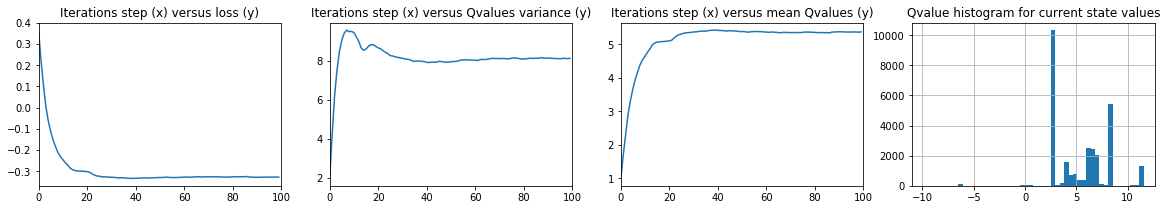

Minimal Q Value: -9.94998883833544
Maximum Q Value: 11.540888477288131
Finished for the set  val
running fqi for eval_type  test


100%|██████████| 21/21 [00:55<00:00,  2.65s/it]


shape of action state  combination:  (3708558, 49)
expected dim is :  3708558   50
dim of X is  (176598, 68)
dim of features big matrix is  (3708558, 68)
shape of y or output is  (176598,)


  1%|          | 1/100 [00:33<54:56, 33.30s/it]

Iteration: 0, test Loss: 0.353988, meanQ: 1.131703, Qvar: 2.108823


  2%|▏         | 2/100 [01:09<57:00, 34.90s/it]

Iteration: 1, test Loss: -0.014921, meanQ: 3.089802, Qvar: 9.730496


  3%|▎         | 3/100 [01:45<57:38, 35.66s/it]

Iteration: 2, test Loss: -0.223805, meanQ: 4.207088, Qvar: 17.508390


  4%|▍         | 4/100 [02:22<57:51, 36.16s/it]

Iteration: 3, test Loss: -0.304037, meanQ: 4.714956, Qvar: 18.947569


  5%|▌         | 5/100 [03:00<58:01, 36.64s/it]

Iteration: 4, test Loss: -0.346450, meanQ: 5.121965, Qvar: 16.647669


  6%|▌         | 6/100 [03:35<56:23, 36.00s/it]

Iteration: 5, test Loss: -0.381602, meanQ: 5.402190, Qvar: 16.197031


  7%|▋         | 7/100 [04:05<52:45, 34.04s/it]

Iteration: 6, test Loss: -0.389504, meanQ: 5.568619, Qvar: 14.115786


  8%|▊         | 8/100 [04:33<49:16, 32.14s/it]

Iteration: 7, test Loss: -0.377058, meanQ: 5.655583, Qvar: 10.844378


  9%|▉         | 9/100 [05:04<48:17, 31.84s/it]

Iteration: 8, test Loss: -0.366596, meanQ: 5.718621, Qvar: 8.387495


 10%|█         | 10/100 [05:31<45:30, 30.34s/it]

Iteration: 9, test Loss: -0.437052, meanQ: 6.199533, Qvar: 9.406916


 11%|█         | 11/100 [05:58<43:31, 29.35s/it]

Iteration: 10, test Loss: -0.529602, meanQ: 6.992846, Qvar: 7.500425


 12%|█▏        | 12/100 [06:27<43:08, 29.41s/it]

Iteration: 11, test Loss: -0.605390, meanQ: 7.652331, Qvar: 7.253115


 13%|█▎        | 13/100 [07:04<45:44, 31.54s/it]

Iteration: 12, test Loss: -0.638997, meanQ: 7.961952, Qvar: 7.818337


 14%|█▍        | 14/100 [07:38<46:08, 32.19s/it]

Iteration: 13, test Loss: -0.596605, meanQ: 7.653021, Qvar: 7.156080


 15%|█▌        | 15/100 [08:11<46:01, 32.49s/it]

Iteration: 14, test Loss: -0.576412, meanQ: 7.507361, Qvar: 7.180678


 16%|█▌        | 16/100 [08:42<45:02, 32.18s/it]

Iteration: 15, test Loss: -0.558789, meanQ: 7.277056, Qvar: 7.771443


 17%|█▋        | 17/100 [09:12<43:34, 31.50s/it]

Iteration: 16, test Loss: -0.543660, meanQ: 7.095163, Qvar: 8.567546


 18%|█▊        | 18/100 [09:40<41:43, 30.54s/it]

Iteration: 17, test Loss: -0.509172, meanQ: 6.834174, Qvar: 8.471653


 19%|█▉        | 19/100 [10:15<42:47, 31.70s/it]

Iteration: 18, test Loss: -0.483533, meanQ: 6.631852, Qvar: 8.570341


 20%|██        | 20/100 [10:48<42:56, 32.21s/it]

Iteration: 19, test Loss: -0.473839, meanQ: 6.526933, Qvar: 9.145272


 21%|██        | 21/100 [11:17<40:56, 31.10s/it]

Iteration: 20, test Loss: -0.485173, meanQ: 6.565256, Qvar: 10.165293


 22%|██▏       | 22/100 [11:45<39:29, 30.37s/it]

Iteration: 21, test Loss: -0.504178, meanQ: 6.701398, Qvar: 10.684054


 23%|██▎       | 23/100 [12:14<38:05, 29.68s/it]

Iteration: 22, test Loss: -0.504669, meanQ: 6.686357, Qvar: 11.134804


 24%|██▍       | 24/100 [12:40<36:32, 28.85s/it]

Iteration: 23, test Loss: -0.500323, meanQ: 6.636291, Qvar: 11.500689


 25%|██▌       | 25/100 [13:08<35:34, 28.46s/it]

Iteration: 24, test Loss: -0.498258, meanQ: 6.607029, Qvar: 11.848600


 41%|████      | 41/100 [20:54<28:29, 28.98s/it]

Iteration: 40, test Loss: -0.513473, meanQ: 6.756472, Qvar: 11.369322


 61%|██████    | 61/100 [31:51<20:48, 32.01s/it]

Iteration: 60, test Loss: -0.527618, meanQ: 6.850692, Qvar: 11.039143


 81%|████████  | 81/100 [42:59<10:27, 33.02s/it]

Iteration: 80, test Loss: -0.524999, meanQ: 6.811185, Qvar: 11.871791


100%|██████████| 100/100 [51:28<00:00, 30.88s/it]



Dimensions of the dataset that is being appended with it's base length for each action:
(176598, 49)


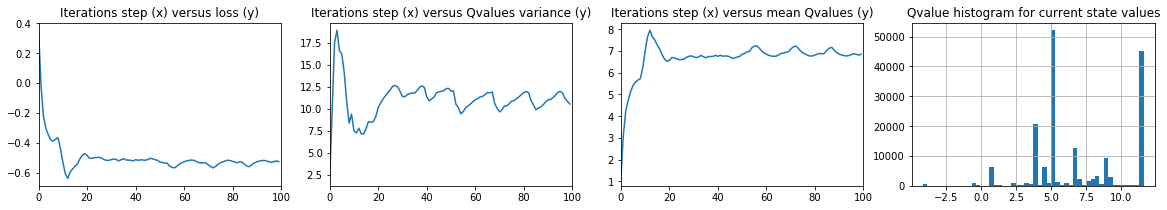

Minimal Q Value: -4.134490780242794
Maximum Q Value: 11.5846326516195
Finished for the set  test
running fqi for eval_type  train


100%|██████████| 21/21 [00:35<00:00,  1.71s/it]


shape of action state  combination:  (2419578, 49)
expected dim is :  2419578   50
dim of X is  (115218, 68)
dim of features big matrix is  (2419578, 68)
shape of y or output is  (115218,)


  1%|          | 1/100 [00:17<29:31, 17.89s/it]

Iteration: 0, train Loss: 0.400643, meanQ: 0.968415, Qvar: 1.912029


  2%|▏         | 2/100 [00:35<29:15, 17.91s/it]

Iteration: 1, train Loss: 0.225927, meanQ: 1.876553, Qvar: 4.025371


  3%|▎         | 3/100 [00:54<29:35, 18.30s/it]

Iteration: 2, train Loss: 0.105352, meanQ: 2.498989, Qvar: 6.097596


  4%|▍         | 4/100 [01:13<29:46, 18.61s/it]

Iteration: 3, train Loss: 0.006308, meanQ: 3.073692, Qvar: 7.466468


  5%|▌         | 5/100 [01:32<29:21, 18.55s/it]

Iteration: 4, train Loss: -0.077517, meanQ: 3.623929, Qvar: 7.967029


  6%|▌         | 6/100 [01:49<28:31, 18.21s/it]

Iteration: 5, train Loss: -0.144623, meanQ: 4.101291, Qvar: 7.946727


  7%|▋         | 7/100 [02:06<27:44, 17.90s/it]

Iteration: 6, train Loss: -0.185396, meanQ: 4.388952, Qvar: 8.267862


  8%|▊         | 8/100 [02:24<27:10, 17.72s/it]

Iteration: 7, train Loss: -0.229408, meanQ: 4.750988, Qvar: 7.705499


  9%|▉         | 9/100 [02:42<27:01, 17.82s/it]

Iteration: 8, train Loss: -0.275443, meanQ: 5.137444, Qvar: 6.920513


 10%|█         | 10/100 [03:00<26:44, 17.82s/it]

Iteration: 9, train Loss: -0.279816, meanQ: 5.154588, Qvar: 7.340639


 11%|█         | 11/100 [03:17<26:12, 17.67s/it]

Iteration: 10, train Loss: -0.284486, meanQ: 5.176289, Qvar: 7.656463


 12%|█▏        | 12/100 [03:34<25:38, 17.48s/it]

Iteration: 11, train Loss: -0.288872, meanQ: 5.204282, Qvar: 7.894184


 13%|█▎        | 13/100 [03:51<25:14, 17.41s/it]

Iteration: 12, train Loss: -0.291806, meanQ: 5.223280, Qvar: 8.012539


 14%|█▍        | 14/100 [04:08<24:49, 17.32s/it]

Iteration: 13, train Loss: -0.294154, meanQ: 5.239815, Qvar: 8.098581


 15%|█▌        | 15/100 [04:26<24:36, 17.38s/it]

Iteration: 14, train Loss: -0.294902, meanQ: 5.248111, Qvar: 8.128417


 16%|█▌        | 16/100 [04:44<24:29, 17.49s/it]

Iteration: 15, train Loss: -0.295496, meanQ: 5.254911, Qvar: 8.120002


 17%|█▋        | 17/100 [05:01<24:01, 17.37s/it]

Iteration: 16, train Loss: -0.296639, meanQ: 5.259305, Qvar: 8.116863


 18%|█▊        | 18/100 [05:18<23:49, 17.43s/it]

Iteration: 17, train Loss: -0.299987, meanQ: 5.275152, Qvar: 8.211934


 19%|█▉        | 19/100 [05:35<23:24, 17.34s/it]

Iteration: 18, train Loss: -0.304291, meanQ: 5.298481, Qvar: 8.332448


 20%|██        | 20/100 [05:51<22:34, 16.94s/it]

Iteration: 19, train Loss: -0.308164, meanQ: 5.319717, Qvar: 8.405723


 21%|██        | 21/100 [06:05<21:05, 16.02s/it]

Iteration: 20, train Loss: -0.309634, meanQ: 5.325087, Qvar: 8.484216


 22%|██▏       | 22/100 [06:19<19:45, 15.20s/it]

Iteration: 21, train Loss: -0.310739, meanQ: 5.326678, Qvar: 8.538881


 23%|██▎       | 23/100 [06:32<18:47, 14.64s/it]

Iteration: 22, train Loss: -0.311710, meanQ: 5.328109, Qvar: 8.557040


 24%|██▍       | 24/100 [06:45<17:58, 14.19s/it]

Iteration: 23, train Loss: -0.312868, meanQ: 5.332508, Qvar: 8.603752


 25%|██▌       | 25/100 [06:58<17:22, 13.91s/it]

Iteration: 24, train Loss: -0.313631, meanQ: 5.334659, Qvar: 8.631023


 41%|████      | 41/100 [11:14<18:56, 19.26s/it]

Iteration: 40, train Loss: -0.314262, meanQ: 5.332158, Qvar: 8.976400


 61%|██████    | 61/100 [17:54<13:25, 20.64s/it]

Iteration: 60, train Loss: -0.313225, meanQ: 5.326589, Qvar: 9.016588


 81%|████████  | 81/100 [25:04<06:41, 21.11s/it]

Iteration: 80, train Loss: -0.313140, meanQ: 5.325806, Qvar: 9.021499


100%|██████████| 100/100 [31:14<00:00, 18.74s/it]



Dimensions of the dataset that is being appended with it's base length for each action:
(115218, 49)


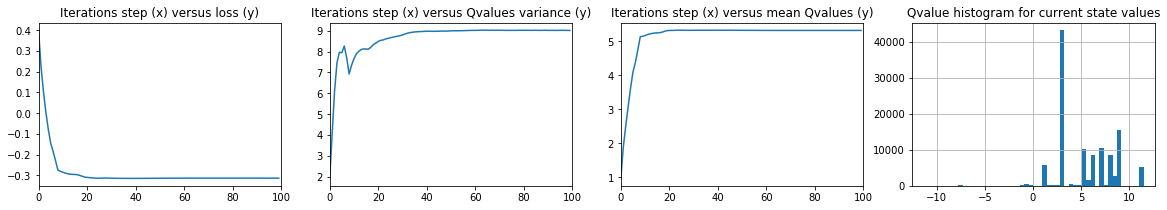

Minimal Q Value: -11.438541562872029
Maximum Q Value: 11.485898846102634
Finished for the set  train


In [8]:
eval_set= ['val', 'test', 'train'] # just change the order to see results  
for eval_type in eval_set :
    print('running fqi for eval_type ', eval_type)
    #get sarsa
    sarsa_dict = get_SARSA_data(data_dict=data_dict, eval_type=eval_type)

    #get modeling data 
    X, output, feat, all_next_states_all_possible_actions = get_state_action_modelingdata(data_dict=data_dict, sarsa_dict=sarsa_dict)
    
    # Create initial RF regressor and set hyperparamters for FQI (gamma for learning, the amount of trees (n_estimators), etc...)
    cont_regr = RandomForestRegressor(max_depth=config['max_depth'], 
                                        random_state=config['FQI_SEED'],
                                        n_estimators=config['n_estimators'],
                                        n_jobs=-1)
    
    # Initialize first RF regressor (thus, only truly fitting between state_action_pair and immediate reward)
    cont_regr.fit(X, output)
    for i in tqdm(range(config['FQI_iterations'])):
        # assign new Q values to dataframe
        all_next_states_all_possible_actions['Qvalue'] = cont_regr.predict(feat)
        # get max Q value for each state ID
        cont_Q_minus_1 = all_next_states_all_possible_actions.groupby(['state_id'], sort=False)['Qvalue'].max()
        # construct the output for the regressor function
        output = sarsa_dict['rewards'] + gamma * (cont_Q_minus_1 * sarsa_dict['reward_mask'])
        # Build the next iteration of the RF regressor
        cont_regr.fit(X, output)
    
        # metric calculation for each loop
        loss = (output - cont_Q_minus_1).mean()
        meanQ = cont_Q_minus_1.mean()
        Qvar = statistics.variance(cont_Q_minus_1)
        # In main loop of the FQI algorithm: Update the performance_dict
        cont_performance_dict[eval_type]['iteration'].append(i)
        cont_performance_dict[eval_type]['loss'].append(loss)
        cont_performance_dict[eval_type]['meanQ'].append(meanQ)
        cont_performance_dict[eval_type]['Qvar'].append(Qvar)
        # Keep track of performance
        if (i % 20 == 0 and i > 0) or i <25:
            print('Iteration: {}, {} Loss: {:4f}, meanQ: {:4f}, Qvar: {:4f}'.format(i, eval_type, loss, meanQ, Qvar))
    
    #prepare file to save 
    cont_results_df = save_physician_mdp(data_dict=data_dict, sarsa_dict=sarsa_dict)
    cont_results_df.to_pickle(os.path.join(out_dir, 'FQI_QValues_' + str(eval_type) + 'data.pkl'))
    
    # Create multiplot
    plt.figure(figsize=(20, 3))

    # Q loss function
    plt.subplot(141)
    plt.plot(cont_performance_dict[eval_type]['iteration'], cont_performance_dict[eval_type]['loss'])
    plt.xlim(0,100)
    plt.title("Iterations step (x) versus loss (y)")

    # Q variance plotting
    plt.subplot(142)
    plt.plot(cont_performance_dict[eval_type]['iteration'], cont_performance_dict[eval_type]['Qvar'])
    plt.xlim(0,100)
    plt.title("Iterations step (x) versus Qvalues variance (y)")

    # Q variance plotting
    plt.subplot(143)
    plt.plot(cont_performance_dict[eval_type]['iteration'], cont_performance_dict[eval_type]['meanQ'])
    plt.xlim(0,100)
    plt.title("Iterations step (x) versus mean Qvalues (y)")

    # Q-value for current_state_joined_with_action
    plt.subplot(144)
    pd.Series(cont_Q_minus_1).hist(bins=50)
    plt.title("Qvalue histogram for current state values")

    # visual inspection
    plt.savefig((os.path.join(fig_dir, 'FQI_QValues_' + str(eval_type) + '.png')))#,dpi=200,transparent=False)
    plt.show()
    
    # find range for visualisation
    print("Minimal Q Value: " + str(cont_Q_minus_1.min()))
    print("Maximum Q Value: " + str(cont_Q_minus_1.max()))
    print('Finished for the set ', eval_type)

    cont_results_df.tail(n=2)




In [9]:
print('Finishedm')

Finishedm


In [10]:
### Run this only if you have Physiscan probability calculated by KNN.physician
# Action probabilities of physician's action used for intermediate evaluateion
train_pi_behavior = pd.read_pickle(os.path.join(data_dir, 'KNN_pi_behavior_' + 'train' + 'data.pkl')) # pi_evaluation
val_pi_behavior = pd.read_pickle(os.path.join(data_dir, 'KNN_pi_behavior_' + 'val' + 'data.pkl')) # pi_evaluation
test_pi_behavior = pd.read_pickle(os.path.join(data_dir, 'KNN_pi_behavior_' + 'test' + 'data.pkl')) # pi_evaluation

# dataset MDP Q function (FQI-SARSA)
train_MDP_Q = pd.read_pickle(os.path.join(data_dir, 'FQI_QValues_' + 'train' + 'data.pkl'))
val_MDP_Q = pd.read_pickle(os.path.join(data_dir, 'FQI_QValues_' + 'val' + 'data.pkl'))
test_MDP_Q = pd.read_pickle(os.path.join(data_dir, 'FQI_QValues_' + 'test' + 'data.pkl'))

In [11]:
for eval_type in ['train', 'val', 'test']:
    if eval_type =='train':
        Q = train_MDP_Q
        pi_behavior = train_pi_behavior
        wdr, wis = eval_WDR(data_dict, eval_type, gamma, pi_behavior, pi_behavior, Q)
        print('the eval_type is ', eval_type, ' wdr is ', wdr , ' wis is ', wis)
    elif eval_type == 'val':
        Q = val_MDP_Q
        pi_behavior = val_pi_behavior
        wdr, wis = eval_WDR(data_dict, eval_type, gamma, pi_behavior, pi_behavior, Q)
        print('the eval_type is ', eval_type, ' wdr is ', wdr , ' wis is ', wis)
    else:
        Q = test_MDP_Q
        pi_behavior = test_pi_behavior
        wdr, wis = eval_WDR(data_dict, eval_type, gamma, pi_behavior, pi_behavior, Q)
        print('the eval_type is ', eval_type, ' wdr is ', wdr , ' wis is ', wis)

the eval_type is  train  wdr is  1.9362055844974326  wis is  1.902074129017351
the eval_type is  val  wdr is  2.350388188149577  wis is  1.814073199873113
the eval_type is  test  wdr is  4.686122186865602  wis is  1.8320082129053081


In [ ]:
#Dont run the script below this part 